In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('../../data/btc.csv')
print(df)

     formatted_date          high           low          open         close  \
0        2019-01-01   3850.913818   3707.231201   3746.713379   3843.520020   
1        2019-01-02   3947.981201   3817.409424   3849.216309   3943.409424   
2        2019-01-03   3935.685059   3826.222900   3931.048584   3836.741211   
3        2019-01-04   3865.934570   3783.853760   3832.040039   3857.717529   
4        2019-01-05   3904.903076   3836.900146   3851.973877   3845.194580   
...             ...           ...           ...           ...           ...   
1420     2022-11-22  16253.047852  15656.606445  15782.300781  16189.769531   
1421     2022-11-23  16638.193359  16170.502930  16195.588867  16610.707031   
1422     2022-11-24  16771.474609  16501.767578  16611.636719  16604.464844   
1423     2022-11-25  16603.316406  16388.404297  16602.269531  16521.841797   
1424     2022-11-26  16666.863281  16521.164062  16524.724609  16620.326172   

           volume      adjclose  
0      4324200990

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['low'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['low'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['low'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['low'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['low'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv("../../data/GRU/bitcoin_processed_low.csv")
df

,formatted_date,high,low,open,close,volume,adjclose,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,2019-01-21,3608.840820,3558.537109,3600.372803,3576.032471,5004347059,3576.032471,50.303711,24.340332,3613.942697,3670.034616,3723.786156,32.285647,152.462873
21,2019-01-22,3620.746582,3539.721436,3575.081299,3604.577148,5313623556,3604.577148,81.025146,-29.495850,3602.481585,3637.375052,3715.809501,42.440931,157.665491
22,2019-01-23,3623.067871,3565.313965,3605.557129,3585.123047,5433755649,3585.123047,57.753906,20.434082,3594.001674,3604.707275,3703.804955,43.191418,159.133311
23,2019-01-24,3616.087402,3569.092773,3584.500244,3600.865479,5262869046,3600.865479,46.994629,-16.365234,3586.449079,3598.272862,3691.560663,42.095987,159.135328
24,2019-01-25,3612.927734,3575.597412,3607.390381,3599.765869,5265847539,3599.765869,37.330322,7.624512,3577.665737,3592.739118,3681.643694,35.699181,159.584655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,2022-11-22,16253.047852,15656.606445,15782.300781,16189.769531,30726828760,16189.769531,596.441406,-407.468750,16218.594587,16212.732701,17497.666481,417.816570,1992.579342
1421,2022-11-23,16638.193359,16170.502930,16195.588867,16610.707031,32958875628,16610.707031,467.690430,-415.118164,16181.507673,16247.576311,17311.160203,407.302000,1920.064964
1422,2022-11-24,16771.474609,16501.767578,16611.636719,16604.464844,26129037414,16604.464844,269.707031,7.171875,16187.376814,16295.272670,17140.471029,412.261163,1817.624905
1423,2022-11-25,16603.316406,16388.404297,16602.269531,16521.841797,18678255976,16521.841797,214.912109,80.427734,16162.204381,16284.195661,16959.536970,390.176501,1683.237633


In [4]:
pre_day = 30
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','open','close','H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['low']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

281
(1094, 30, 10) (1094, 1) (281, 30, 10) (281, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
model.save("../../model/GRU/bitcoin_GRU_8_2_low.h5")

Epoch 1/120
40/40 [==============================] - 12s 38ms/step - loss: 0.0197
Epoch 2/120
40/40 [==============================] - 2s 41ms/step - loss: 0.0046
Epoch 3/120
40/40 [==============================] - 2s 47ms/step - loss: 0.0043
Epoch 4/120
40/40 [==============================] - 2s 46ms/step - loss: 0.0038
Epoch 5/120
40/40 [==============================] - 2s 48ms/step - loss: 0.0043
Epoch 6/120
40/40 [==============================] - 2s 48ms/step - loss: 0.0040
Epoch 7/120
40/40 [==============================] - 2s 47ms/step - loss: 0.0032
Epoch 8/120
40/40 [==============================] - 2s 50ms/step - loss: 0.0027
Epoch 9/120
40/40 [==============================] - 2s 48ms/step - loss: 0.0040
Epoch 10/120
40/40 [==============================] - 2s 47ms/step - loss: 0.0030
Epoch 11/120
40/40 [==============================] - 2s 49ms/step - loss: 0.0027
Epoch 12/120
40/40 [==============================] - 2s 46ms/step - loss: 0.0028
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_test)
predict_price = scala_y.inverse_transform(predict_price)

9/9 [==============================] - 3s 12ms/step


(281, 1)


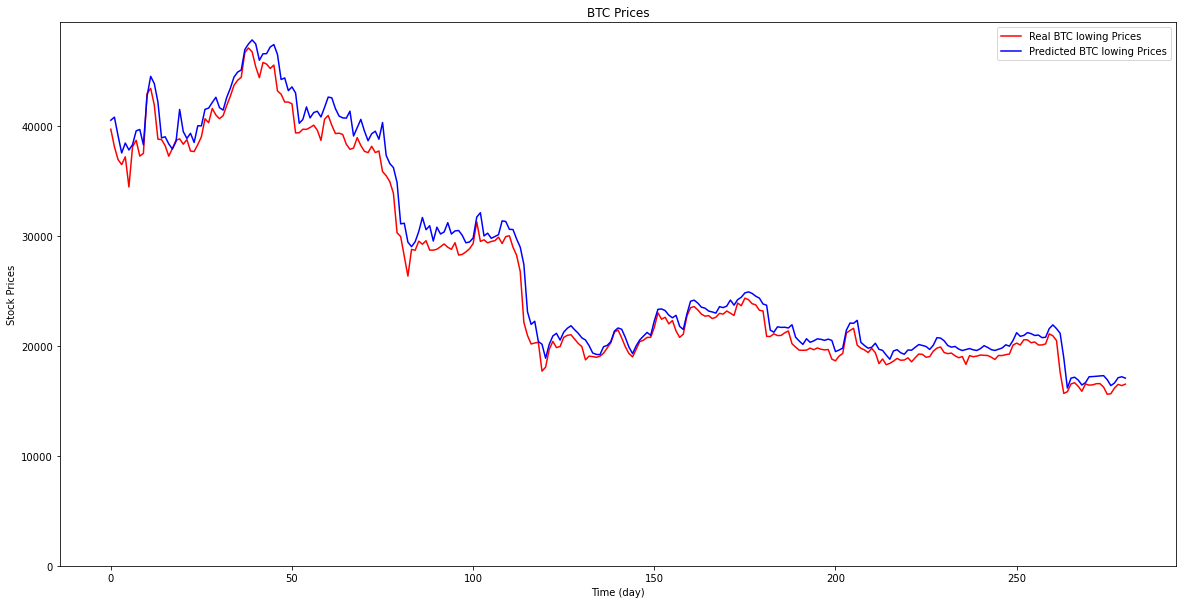

In [7]:
# Ploting the stat
real_price = df[len(df)-test_size:]['low'].values.reshape(-1,1)
real_price = np.array(real_price)
print(real_price.shape)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.figure(figsize=(20,10))
plt.plot(real_price, color="red", label=f"Real BTC lowing Prices")
plt.plot(predict_price, color="blue", label=f"Predicted BTC lowing Prices")
plt.title(f"BTC Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [8]:
# Make Prediction
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

prediction = model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 19ms/step
[[17068.004]]


In [9]:
mae = mean_absolute_error(real_price, predict_price)
mape = mean_absolute_percentage_error(real_price, predict_price)
mse = mean_squared_error(real_price, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1056.76
MAPE: 4.06%
MSE: 1793418.30
RMSE: 1339.19
R2: 0.98
